In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import datetime
import subprocess
import time

In [2]:
#def inicitializa_db():
spark = SparkSession.builder \
    .appName("Spark SQL Hive Integration") \
    .master("local[*]") \
    .getOrCreate()

spark.sql("CREATE DATABASE IF NOT EXISTS data")
spark.sql("DROP TABLE IF EXISTS data.bronze")
spark.sql("DROP TABLE IF EXISTS data.silver")
spark.sql("DROP TABLE IF EXISTS data.gold")
spark.sql("DROP TABLE IF EXISTS data.medellin")
spark.sql("DROP TABLE IF EXISTS data.customers")
spark.sql("DROP TABLE IF EXISTS data.employees")
spark.sql("DROP TABLE IF EXISTS data.neigbohoods")

df_50001 = spark.read.parquet('/data/50001.parquet')
df_customers = spark.read.parquet('/data/customers.parquet')
df_employees = spark.read.parquet('/data/employees.parquet')
df_neighborhoods = spark.read.parquet('/data/medellin_neighborhoods.parquet')
    
df_50001.write.mode('append').saveAsTable('data.medellin')
df_customers.write.mode('append').saveAsTable('data.customers')
df_employees.write.mode('append').saveAsTable('data.employees')
df_neighborhoods.write.mode('append').saveAsTable('data.neigbohoods')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
def raw_to_silver():
    # Crear sesión de Spark
    #spark = SparkSession \
    #    .builder \
    #    .appName("Silver Zone Creation") \
    #    .master("local[*]") \
    #    .getOrCreate()

    # Definir la ruta base en HDFS
    #hdfs_base_path = 'hdfs://localhost:9000'

    # Leer cada archivo Parquet
    #df_50001 = spark.read.parquet(hdfs_base_path + '/data/50001.parquet')
    #df_customers = spark.read.parquet(hdfs_base_path + '/data/customers.parquet')
    df_data_raw = spark.read.parquet('/raw/new/*.parquet')
    #df_employees = spark.read.parquet(hdfs_base_path + '/data/employees.parquet')
    df_neighborhoods = spark.read.parquet('/data/medellin_neighborhoods.parquet')

    # Crear la base de datos bronze si no existe
    #spark.sql("CREATE DATABASE IF NOT EXISTS bronze")
    # Guardar los datos como una tabla en la base de datos bronze
    df_data_raw.write.mode('append').saveAsTable('data.bronze')

    df_silver = df_data_raw.withColumn("event_date", to_timestamp(col("date"), "dd/MM/yyyy HH:mm:ss")) \
        .withColumn("partition_date", date_format(col("event_date"), "ddMMyyyy")) \
        .withColumn("event_day", dayofmonth(col("event_date"))) \
        .withColumn("event_hour", hour(col("event_date"))) \
        .withColumn("event_minute", minute(col("event_date"))) \
        .withColumn("event_month", month(col("event_date"))) \
        .withColumn("event_second", second(col("event_date"))) \
        .withColumn("event_year", year(col("event_date"))) \
        .withColumnRenamed("order_id", "order_id") \
        .withColumnRenamed("employee_id", "employee_id") \
        .withColumnRenamed("quantity_products", "quantity_products") \
        .withColumnRenamed("latitude", "latitude") \
        .withColumnRenamed("longitude", "longitude") \
        .withColumnRenamed("customer_id", "customer_id")

    # Eliminar la columna original de fecha si no es necesaria
    df_silver = df_silver.drop("date")

    # Seleccionar solo las columnas NOMBRE e IDENTIFICACION de df_neighborhoods, y renombrar OBJECTID a object_id
    df_neighborhoods_seleccionado = df_neighborhoods.select(
        col("OBJECTID").alias("object_id"),
        col("NOMBRE").alias("neighborhood"),
        col("IDENTIFICACION").alias("commune")
    )

    # Realizar el left join en la columna object_id
    df_resultado = df_silver.join(
        df_neighborhoods_seleccionado,
        df_silver['object_id'] == df_neighborhoods_seleccionado['object_id'],
        "left"
    ).select(
        df_silver['*'],  # Seleccionar todas las columnas de df_silver
        df_neighborhoods_seleccionado['neighborhood'],  # Seleccionar la columna renombrada neighborhood
        df_neighborhoods_seleccionado['commune']  # Seleccionar la columna renombrada commune
    ).drop(df_silver['object_id'])  # Eliminar la columna object_id del resultado final

    # Guardar datos procesados en la zona Silver
    current_time = datetime.now().strftime("%Y%m%d%H%M%S")
    output_path = "/silver/new/data_silver_"+current_time+".parquet"
    df_resultado.write.mode('overwrite').parquet(output_path)

    # Mover a carpeta de procesados
    src_path = "/raw/new/*.parquet"
    dest_path = "/raw/processed/"
    cmd = f"hdfs dfs -mv {src_path} {dest_path}"
    result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    # Detener sesión de Spark
    #spark.stop()

In [4]:
def silver_to_gold():
    # Crear sesión de Spark
    #spark = SparkSession.builder \
    #    .appName("Gold Zone Creation") \
    #    .master("local[*]") \
    #    .getOrCreate()

    # Leer datos de la zona Silver
    silver_path = "/silver/new/*.parquet"
    silver_df = spark.read.parquet(silver_path)

    # Crear las tablas en SQL en gold
    #spark.sql("CREATE DATABASE IF NOT EXISTS silver")
    silver_df.write.mode('append').saveAsTable('data.silver')
    
    # Leer datos complementarios
    customers_df = spark.read.parquet("/data/customers.parquet")
    employees_df = spark.read.parquet("/data/employees.parquet")

    # Agregar información de clientes
    silver_df = silver_df.join(customers_df, silver_df.customer_id == customers_df.customer_id, "left") \
        .select(silver_df["*"], customers_df["name"].alias("customer_name"), customers_df["phone"].alias("customer_phone"), customers_df["email"].alias("customer_email"), customers_df["address"].alias("customer_address"))

    # Agregar información de empleados
    silver_df = silver_df.join(employees_df, silver_df.employee_id == employees_df.employee_id, "left") \
        .select(silver_df["*"], employees_df["name"].alias("employee_name"), employees_df["phone"].alias("employee_phone"), employees_df["email"].alias("employee_email"), employees_df["address"].alias("employee_address"), employees_df["comission"].alias("employee_commission"))

    # Ventas detalladas
    detailed_sales_df = silver_df.select(
        "order_id", 
        # "customer_id", 
        "customer_name", 
        # "customer_phone", 
        # "customer_email", 
        # "customer_address", 
        # "employee_id", 
        "employee_name", 
        # "employee_phone", 
        # "employee_email", 
        # "employee_address", 
        "employee_commission", 
        "latitude",
        "longitude",
        "commune", 
        "neighborhood", 
        "quantity_products", 
        "event_date"
    )

    # Obtener la fecha y hora actual para el nombre del archivo
    current_time = datetime.now().strftime("%Y%m%d%H%M%S")
    output_path = "/gold/detailed_sales_"+current_time+".parquet"

    # Guardar datos procesados en la zona Gold
    detailed_sales_df.write.mode('overwrite').parquet(output_path)

    # Crear las tablas en SQL en gold
    #spark.sql("CREATE DATABASE IF NOT EXISTS gold")
    detailed_sales_df.write.mode('append').saveAsTable('data.gold')

    # Mover cada archivo
    src_path = "/silver/new/*.parquet"
    dest_path = "/silver/processed/"
    cmd = f"hdfs dfs -mv {src_path} {dest_path}"
    result = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Mover archivos de silver/new a silver/processed
    #processed_path = "hdfs://namenode:9000/silver/processed"

    # Listar los archivos en la ruta silver/new
    #fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    #files_to_move = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(silver_path))

    # Mover cada archivo
    #for file in files_to_move:
        #old_path = file.getPath()
        #new_path = spark._jvm.org.apache.hadoop.fs.Path(os.path.join(processed_path, old_path.getName()))
        #fs.rename(old_path, new_path)

    # Detener sesión de Spark
    #spark.stop()


In [10]:
raw_to_silver()

In [11]:
silver_to_gold()

In [9]:
n = 1
while True:
    time.sleep(1800)
    raw_to_silver()
    if n==2:
        silver_to_gold()
        n = 1
    n += 1
    

KeyboardInterrupt: 

In [12]:
tables_bronze = spark.sql("SHOW DATABASES")
tables_bronze.show()

+---------+
|namespace|
+---------+
|     data|
|  default|
+---------+



In [13]:
tables_bronze = spark.sql("SHOW TABLES FROM data")
tables_bronze.show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|    data|     bronze|      false|
|    data|  customers|      false|
|    data|  employees|      false|
|    data|       gold|      false|
|    data|   medellin|      false|
|    data|neigbohoods|      false|
|    data|     silver|      false|
+--------+-----------+-----------+



In [73]:
spark.sql("SELECT * FROM data.bronze").orderBy(desc("order_id")).show(truncate=False)

+---------+------------------+------------------+-------------------+-----------+-----------+-----------------+------------------------------------+
|object_id|latitude          |longitude         |date               |customer_id|employee_id|quantity_products|order_id                            |
+---------+------------------+------------------+-------------------+-----------+-----------+-----------------+------------------------------------+
|326      |6.2933392820791   |-75.57543431005836|21/06/2024 18:31:26|8566       |9438       |627              |d8b9b417-b098-4344-b137-362894e4dcgs|
|337      |6.272703723685749 |-75.66630375214945|21/06/2024 18:31:26|7530       |3830       |248              |d8b9b417-b098-4344-b137-362894e4dcgr|
|339      |6.1939160192933205|-75.5276128503188 |21/06/2024 18:31:26|2733       |4942       |430              |d8b9b417-b098-4344-b137-362894e4dcgq|
|336      |6.2898095960461395|-75.67758282547585|21/06/2024 18:31:26|5102       |3830       |720          

In [18]:
spark.sql("SELECT * FROM data.silver").orderBy(desc("order_id")).show(truncate=False)

+------------------+------------------+-----------+-----------+-----------------+------------------------------------+-------------------+--------------+---------+----------+------------+-----------+------------+----------+------------------------------------------+----------------+
|latitude          |longitude         |customer_id|employee_id|quantity_products|order_id                            |event_date         |partition_date|event_day|event_hour|event_minute|event_month|event_second|event_year|neighborhood                              |commune         |
+------------------+------------------+-----------+-----------+-----------------+------------------------------------+-------------------+--------------+---------+----------+------------+-----------+------------+----------+------------------------------------------+----------------+
|6.2933392820791   |-75.57543431005836|8566       |9438       |627              |d8b9b417-b098-4344-b137-362894e4dcgs|2024-06-21 18:31:26|21062024  

In [17]:
spark.sql("SELECT * FROM data.gold").orderBy(desc("order_id")).show(truncate=False)

+------------------------------------+-----------------+-----------------+-------------------+------------------+------------------+----------------+------------------------------------------+-----------------+-------------------+
|order_id                            |customer_name    |employee_name    |employee_commission|latitude          |longitude         |commune         |neighborhood                              |quantity_products|event_date         |
+------------------------------------+-----------------+-----------------+-------------------+------------------+------------------+----------------+------------------------------------------+-----------------+-------------------+
|d8b9b417-b098-4344-b137-362894e4dcgs|Tatum Finley     |Dacey Barr       |0.02               |6.2933392820791   |-75.57543431005836|COMUNA 6        |DOCE DE OCTUBRE                           |627              |2024-06-21 18:31:26|
|d8b9b417-b098-4344-b137-362894e4dcgr|Prescott Hatfield|Shaeleigh Turner |0.

In [24]:
df = spark.sql("SELECT * FROM data.gold")

In [33]:
df.write.csv("file:///workspace/data_gold",header=True,mode="overwrite" )

In [32]:
!ls /tmp

Jetty_0_0_0_0_50070_hdfs____w2cu08
Jetty_0_0_0_0_50090_secondary____y6aanv
Jetty_0_0_0_0_8042_node____19tj0x
Jetty_0_0_0_0_8088_cluster____u0rgz3
Jetty_localhost_35941_datanode____.7fdf0l
blockmgr-3a22b263-1687-4b3e-929e-e80a41bc92fb
blockmgr-4e6acca6-2595-4f30-895d-2f20dc8543a6
blockmgr-53cf20b1-478c-4e73-9388-d4d5dd56611e
data_gold
data_gold.csv
devcontainers-c8ede362-dd5d-4bea-bc0a-c5eac77031941718996330278
devcontainers-d284f1da-b782-4cba-b46f-9ebc5a084ac41718996373275
hadoop-root
hadoop-root-datanode.pid
hadoop-root-namenode.pid
hadoop-root-secondarynamenode.pid
hsperfdata_root
liblz4-java-3941417813265118985.so
liblz4-java-3941417813265118985.so.lck
liblz4-java-6518985352252515161.so
liblz4-java-6518985352252515161.so.lck
snappy-1.0.5-490aab39-846c-475e-950e-aa2ba9765407-libsnappyjava.so
snappy-1.0.5-d3bfa40e-4011-4c28-bbcc-0d5d196ccc92-libsnappyjava.so
spark-0ac61ff1-10e0-482e-b08e-f6977b460ef8
spark-0e468879-cc78-4335-bf92-e5d213879006
spark-246b4979-bfd7-4716-a284-04047704d1ac

In [35]:
pandas_df = df.toPandas()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   neighborhood       21 non-null     object
 1   quantity_products  21 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 380.0+ bytes


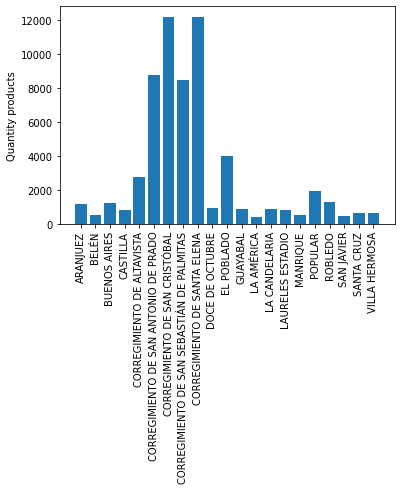

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
df1 = pandas_df[['neighborhood','quantity_products' ]]
df_gen = df1.groupby(['neighborhood']).sum()
df_gen = df_gen.reset_index()
df_gen.info()
x = df_gen['neighborhood'].values
y = df_gen['quantity_products'].values
plt.bar(x,y)
plt.xticks(rotation=90)
#plt.grid()
plt.ylabel('Quantity products')
plt.show()

/tmp/ipykernel_1421/2629574780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['event_date'] = df1['event_date'].astype(str)


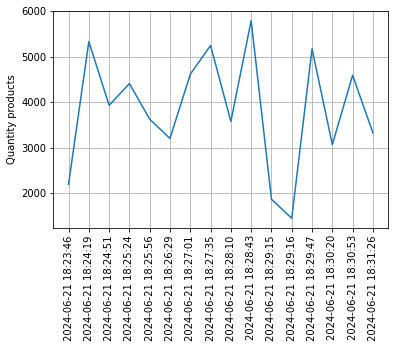

In [ ]:
df1 = pandas_df[['event_date','quantity_products' ]]
df1['event_date'] = df1['event_date'].astype(str)
#df1.info()
df_gen = df1.groupby(['event_date']).sum()
#df_gen = df_gen.reset_index()
#df_gen.info()
plt.plot(df_gen['quantity_products'])
#x = df_gen['neighborhood'].values
#y = df_gen['quantity_products'].values
#plt.bar(x,y)
plt.xticks(rotation=90)
plt.grid()
plt.ylabel('Quantity products')
plt.show()